# Lab 2: Hotel reviews

Generate word clouds for good and bad hotel reviews

Objectives:
- part of speech tagging with spacy
- extract phrases that match a part of speech pattern
- scale processing pipeline with nlp.pipe
- compute c-values

In [1]:
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm import tqdm
from wordcloud import WordCloud

In [2]:
df = pd.read_pickle("/data/hotels.pkl.gz")

In [3]:
df.head()

,title,text,overall,value,service,cleanliness
0,“Perfect/Reasonable”,We spent four days at the La Quinta Downtown l...,4.0,5.0,3.0,4.0
1,“Absolutely loved it”,The room was pleasant and the breakfast just f...,4.0,4.0,3.0,4.0
2,“Our regular at NY City”,Our ladies' troup have become a regular visito...,4.0,4.0,4.0,5.0
3,“Reccommended”,"The hotel has a great location, situated behin...",4.0,4.0,4.0,4.0
4,“Great hotel!!”,I am currently staying at this hotel while I f...,5.0,5.0,5.0,5.0


---

In [4]:
df['text'] = df['title'] + " " + df['text']

In [5]:
df.head()

,title,text,overall,value,service,cleanliness
0,“Perfect/Reasonable”,“Perfect/Reasonable” We spent four days at the...,4.0,5.0,3.0,4.0
1,“Absolutely loved it”,“Absolutely loved it” The room was pleasant an...,4.0,4.0,3.0,4.0
2,“Our regular at NY City”,“Our regular at NY City” Our ladies' troup hav...,4.0,4.0,4.0,5.0
3,“Reccommended”,"“Reccommended” The hotel has a great location,...",4.0,4.0,4.0,4.0
4,“Great hotel!!”,“Great hotel!!” I am currently staying at this...,5.0,5.0,5.0,5.0


## Collect candidate term phrases

Collect all sequences of words that match the part-of-speech pattern `(Adj|Noun)+ Noun`

In [6]:
import spacy
from spacy.matcher import Matcher

In [7]:
nlp = spacy.load(
    "en_core_web_sm", exclude=["parser", "ner", "lemmatizer", "attribute_ruler"]
) 

In [8]:
matcher = Matcher(nlp.vocab)
matcher.add(
    "Term",
    [
        [
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP"]}},
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP", "HYPH"]}, "OP": "*"},
            {"TAG": {"IN": ["NN", "NNS", "NNP"]}},
        ]
    ],
)

In [9]:
def get_phrases(doc):
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]


In [10]:
doc = nlp(df['text'].iloc[0])

In [11]:
print([(t,t.tag_) for t in doc])

[(“, '``'), (Perfect, 'NNP'), (/, 'SYM'), (Reasonable, 'JJ'), (”, "''"), (We, 'PRP'), (spent, 'VBD'), (four, 'CD'), (days, 'NNS'), (at, 'IN'), (the, 'DT'), (La, 'NNP'), (Quinta, 'NNP'), (Downtown, 'NNP'), (last, 'JJ'), (week, 'NN'), (and, 'CC'), (could, 'MD'), (n't, 'RB'), (have, 'VB'), (been, 'VBN'), (more, 'RBR'), (pleased, 'JJ'), (., '.'), (The, 'DT'), (hotel, 'NN'), (was, 'VBD'), (impeccably, 'RB'), (clean, 'JJ'), (,, ','), (the, 'DT'), (breakfast, 'NN'), (was, 'VBD'), (bountiful, 'JJ'), (and, 'CC'), (the, 'DT'), (location, 'NN'), (was, 'VBD'), (convenient, 'JJ'), (to, 'IN'), (everything, 'NN'), (you, 'PRP'), (wanted, 'VBD'), (to, 'TO'), (do, 'VB'), (., '.'), (The, 'DT'), (price, 'NN'), (was, 'VBD'), (fabulous, 'JJ'), (!, '.'), (We, 'PRP'), (would, 'MD'), (highly, 'RB'), (recommend, 'VB'), (it, 'PRP'), (!, '.')]


In [12]:
print(list(get_phrases(doc)))# these are phrases  of row 1 text column that are matched to the part of speech

[('la', 'quinta'), ('quinta', 'downtown'), ('la', 'quinta', 'downtown'), ('last', 'week'), ('downtown', 'last', 'week'), ('quinta', 'downtown', 'last', 'week'), ('la', 'quinta', 'downtown', 'last', 'week')]


In [13]:
candidates = list(
    concat(map(get_phrases, nlp.pipe(tqdm(df["text"]), batch_size=20, n_process=4)))
)


100%|██████████| 231294/231294 [09:21<00:00, 411.66it/s]


In [14]:
import pickle

with open("cands.pkl", "wb") as out:
    pickle.dump(candidates, out)
# this cell stores the data in a pickle

In [15]:
candidates[:10]

[('la', 'quinta'),
 ('quinta', 'downtown'),
 ('la', 'quinta', 'downtown'),
 ('last', 'week'),
 ('downtown', 'last', 'week'),
 ('quinta', 'downtown', 'last', 'week'),
 ('la', 'quinta', 'downtown', 'last', 'week'),
 ('times', 'square'),
 ('tkts', 'booth'),
 ('half', 'block')]

In [16]:
freqs = defaultdict(nltk.FreqDist)
for c in candidates:
    freqs[len(c)][c] += 1

In [17]:
freqs.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 11, 15, 16, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118, 121])

In [18]:
freqs[7]

FreqDist({('=', '=', '=', '=', '=', '=', '='): 88, ('off', '-on', '-', 'off', '-on', '-', 'off'): 39, ('s', '-', 'l', '-', 'o', '-', 'w'): 7, ('o', '-', 'o', '-', 'o', '-', 'o'): 7, ('l', '-', 'o', '-', 'o', '-', 'o'): 5, ('v', '-', 'e', '-', 'r', '-', 'y'): 5, ('preauth', 'ocean', 'park', 'inn', 'ocean', 'park', 'inn'): 5, ('jw', 'marriott', 'san', 'antonio', 'hill', 'country', 'resort'): 4, ('s', '-', 'l', '-', 'o', '-', 'w.'): 4, ('ocean', 'park', 'inn', 'ocean', 'park', 'inn', 'san'): 4, ...})

In [19]:
#freqs[7].most_common()

-----

## Extract terms

Calculate c-values for candidate phrases

$$\textrm{C-value}(a)=
\begin{cases}
\log_2|a|\cdot f(a) & \mbox{if } a \mbox{ is not nested}\\
\log_2|a|\left(f(a)-\frac{1}{P(T_a)}\sum_{b\in T_a}f(b)\right) & \mbox{otherwise}\\
\end{cases}
$$

and select terms above threshold value $\theta$

In [20]:
def get_subterms(term):
    k = len(term)
    for m in range(k - 1, 1, -1):
        yield from nltk.ngrams(term, m)


def c_value(F, theta):

    termhood = nltk.FreqDist()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = np.log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood # frequency of  that term

In [21]:
terms = c_value(freqs, theta=150)

In [22]:
terms.most_common(10)

[(('front', 'desk'), 44951.9),
 (('great', 'location'), 34350.5),
 (('new', 'york'), 22084.1),
 (('times', 'square'), 15913.0),
 (('great', 'hotel'), 14015.0),
 (('room', 'service'), 13098.8),
 (('front', 'desk', 'staff'), 12226.400730562998),
 (('check', '-', 'in'), 10533.660779792803),
 (('good', 'location'), 9844.0),
 (('san', 'francisco'), 9293.5)]

Check threshold: are the items at the bottom of the list (with the lowest c-values) really terms? If not, increase $\theta$ and try again. Repeat until we're happy with the results.

In [23]:
terms.most_common()[-10:]# last 10 elements]


[(('next', 'week'), 151.0),
 (('bell', 'men'), 151.0),
 (('mall', 'area'), 151.0),
 (('street', 'station'), 151.0),
 (('ocean', 'park', 'inn'), 150.57143756850982),
 (('san', 'francisco', 'hotel'), 150.57143756850982),
 (('e', '-', 'mails'), 150.57143756850982),
 (('major', 'tourist', 'attractions'), 150.57143756850982),
 (('great', 'business', 'hotel'), 150.57143756850982),
 (('=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '='),
  150.11730005192322)]

In [24]:
terms.most_common()[-10:]

[(('next', 'week'), 151.0),
 (('bell', 'men'), 151.0),
 (('mall', 'area'), 151.0),
 (('street', 'station'), 151.0),
 (('ocean', 'park', 'inn'), 150.57143756850982),
 (('san', 'francisco', 'hotel'), 150.57143756850982),
 (('e', '-', 'mails'), 150.57143756850982),
 (('major', 'tourist', 'attractions'), 150.57143756850982),
 (('great', 'business', 'hotel'), 150.57143756850982),
 (('=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '=',
   '='),
  150.11730005192322)]

In [25]:
terms.most_common(10)

[(('front', 'desk'), 44951.9),
 (('great', 'location'), 34350.5),
 (('new', 'york'), 22084.1),
 (('times', 'square'), 15913.0),
 (('great', 'hotel'), 14015.0),
 (('room', 'service'), 13098.8),
 (('front', 'desk', 'staff'), 12226.400730562998),
 (('check', '-', 'in'), 10533.660779792803),
 (('good', 'location'), 9844.0),
 (('san', 'francisco'), 9293.5)]

In [26]:
with open('terms.txt', 'w') as f:
    for term in terms:
        print(' '.join(term), file=f)# terms are joined with space inbetween

-----

## Multi-word tokenizer

Here we define a tokenizer that recognizes multi-word terms as single tokens

In [27]:
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans

In [28]:
nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)
phraser = PhraseMatcher(nlp.vocab, attr="LOWER")# phrasematcher object creation


In [29]:
with open('terms.txt', 'r') as f:
    phraser.add("TERM", [nlp.tokenizer(t.strip()) for t in f])


In [30]:
def tokenize(text, sep="_"):
    doc = nlp.tokenizer(text)
    with doc.retokenize() as r:
        for span in filter_spans(phraser(doc, as_spans=True)):
            r.merge(span)
    return [t.norm_.replace(" ", sep) for t in doc if not t.is_space and not t.is_punct]

In [31]:
print(tokenize(df['text'].iloc[37]))

['not', 'what', 'i', 'expected', 'after', 'a', 'very', 'long_trip', 'we', 'were', 'very', 'excited', 'to', 'arrive', 'to', 'our', 'hotel', 'upon', 'entering', 'the', 'lobby', 'we', 'were', 'very', 'impressed', 'by', 'its', 'decor', 'even', 'though', 'they', 'slammed', 'the', 'door', 'on', 'us', 'as', 'we', 'were', 'carrying', 'our', 'luggage', 'when', 'we', 'checked', 'in', 'i', 'was', 'very', 'surprised', 'to', 'find', 'we', 'had', 'a', 'room', 'for', '1', 'that', 'had', 'a', 'single_bed', 'when', 'we', 'booked', '2', 'beds', 'they', 'were', 'rude', 'and', 'not', 'helpful', 'in', 'providing', 'another', 'room', 'which', 'we', 'specified', 'on', 'before', 'arriving', 'since', 'it', 'was', 'a', 'long_trip', 'we', 'asked', 'for', 'dining', 'suggestion', 'and', 'the', 'lady', 'was', 'not', 'forthcoming', 'so', 'we', 'wondered', 'around', 'and', 'found', 'a', 'lovely_place', 'to', 'eat', 'in', 'chinatown', 'while', 'the', 'room', 'was', 'small', 'and', 'they', 'would', 'not', 'provide', 'a

In [32]:
#total = nltk.FreqDist(tokenize(df["text"].iloc[37]))

In [33]:
total = nltk.FreqDist(concat(df["text"].apply(tokenize)))

In [34]:
total.most_common(10)

[('the', 2380176),
 ('and', 1288371),
 ('a', 1063225),
 ('to', 936935),
 ('was', 805730),
 ('i', 656455),
 ('in', 605586),
 ('we', 524586),
 ('of', 500056),
 ('is', 462554)]

## ----

## Word clouds

In this last section, use the tokenizer defined above to make some word clouds comparing good and bad hotels (let's say good = five stars and bad = one or two stars). You might want to look at both the overall rating and some of the sub-scores (like value and service). Can you draw any conclusions that might be useful for hotel owners and managers?

When you are finished, download your notebook file (with a name ending in .ipynb) and submit it via Canvas.

In [35]:
def cloud(freqs, title, k=50):
    plt.figure(figsize=(8, 8))
    wc = WordCloud(
        width=750, height=750, background_color="black"
    ).generate_from_frequencies(freqs)
    plt.title(title)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

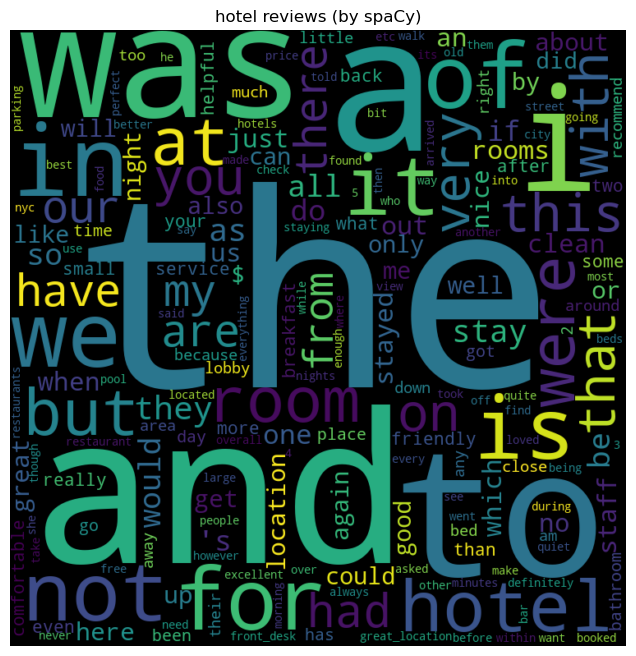

In [36]:
cloud(total, "hotel reviews (by spaCy)")

In [37]:
df.head()

,title,text,overall,value,service,cleanliness
0,“Perfect/Reasonable”,“Perfect/Reasonable” We spent four days at the...,4.0,5.0,3.0,4.0
1,“Absolutely loved it”,“Absolutely loved it” The room was pleasant an...,4.0,4.0,3.0,4.0
2,“Our regular at NY City”,“Our regular at NY City” Our ladies' troup hav...,4.0,4.0,4.0,5.0
3,“Reccommended”,"“Reccommended” The hotel has a great location,...",4.0,4.0,4.0,4.0
4,“Great hotel!!”,“Great hotel!!” I am currently staying at this...,5.0,5.0,5.0,5.0


In [38]:
bad = nltk.FreqDist(concat(df.query(("overall<3")and("value<3")and("service<3"))["text"].apply(tokenize)))
good = nltk.FreqDist(concat(df.query(("overall== 5")and("value>3")and ("service>3"))["text"].apply(tokenize)))

In [39]:
good.most_common(5)


[('the', 1524931),
 ('and', 871881),
 ('a', 695782),
 ('to', 584451),
 ('was', 512953)]

In [40]:
bad.most_common(5)

[('the', 324936),
 ('and', 154337),
 ('to', 148939),
 ('a', 130155),
 ('i', 118806)]

In [41]:
metrics = nltk.BigramAssocMeasures()

In [42]:
bad_llr = nltk.FreqDist()
bad_pmi = nltk.FreqDist()

for w in bad:
    if bad[w] > 15:
        bad_llr[w] = metrics.likelihood_ratio(bad[w], (total[w], bad.N()), total.N())
        bad_pmi[w] = metrics.pmi(bad[w], (total[w], bad.N()), total.N())

In [43]:
bad_llr.most_common(10)

[('told', 12876.460872414897),
 ('not', 11733.525463397615),
 ('very', 10800.857369803183),
 ('they', 8391.105587747585),
 ('he', 8135.21369420874),
 ('great', 8004.395642596019),
 ('i', 7349.0068984072495),
 ('friendly', 7073.097163672046),
 ('rude', 6906.96589075833),
 ('said', 6852.959924433351)]

In [44]:
bad_pmi.most_common(10)

[('disrespected', 2.6419060006178654),
 ('terrible_customer_service', 2.6037708717310935),
 ('horrible_customer_service', 2.5623618022544186),
 ('liars', 2.521611766900154),
 ('poor_customer_service', 2.519353674341982),
 ('bbb', 2.509948849374574),
 ('humiliated', 2.5005501513723267),
 ('unaccomodating', 2.495064612288594),
 ('horrible_service', 2.490708207244456),
 ('unprofessionalism', 2.483476638013382)]

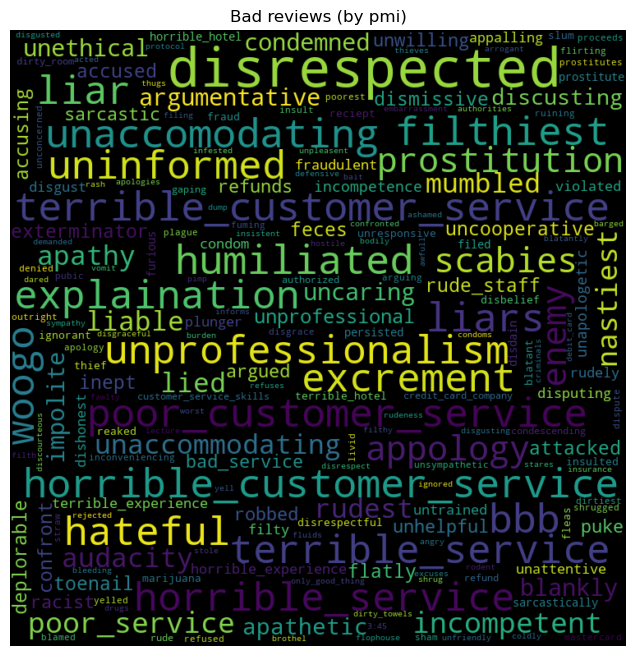

In [45]:
cloud(bad_pmi, "Bad reviews (by pmi)")

In [46]:
#From the above word cloud we can conclude that there are certain problems like- lack of accomodation,
#disrespectful staff,bad customer service. The hotel managers and owners should concentrate on these problems.

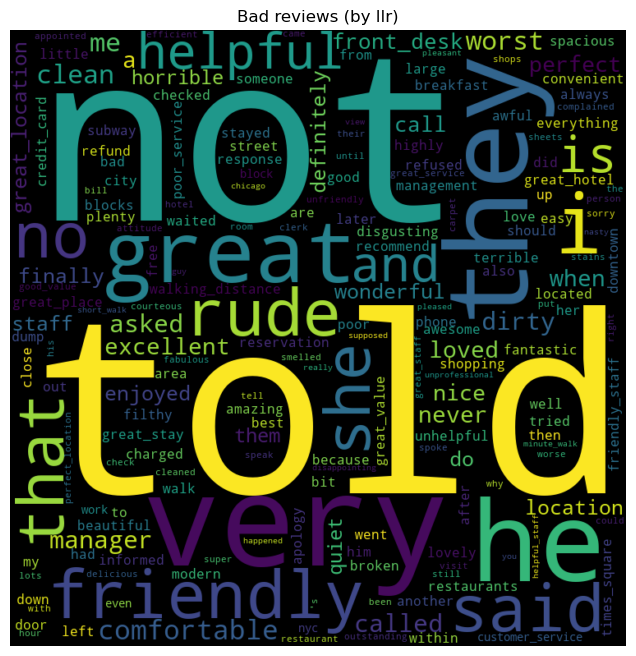

In [47]:
cloud(bad_llr, "Bad reviews (by llr)")

In [48]:
good_llr = nltk.FreqDist()
good_pmi = nltk.FreqDist()

for w in good:
    if good[w] > 10:
        good_llr[w] = metrics.likelihood_ratio(good[w], (total[w], good.N()), total.N())
        good_pmi[w] = metrics.pmi(good[w], (total[w], good.N()), total.N())




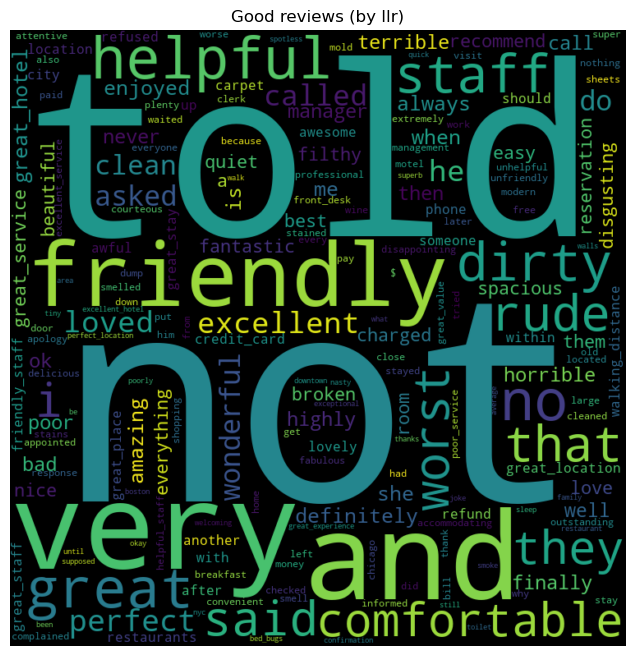

In [49]:
cloud(good_llr, "Good reviews (by llr)")

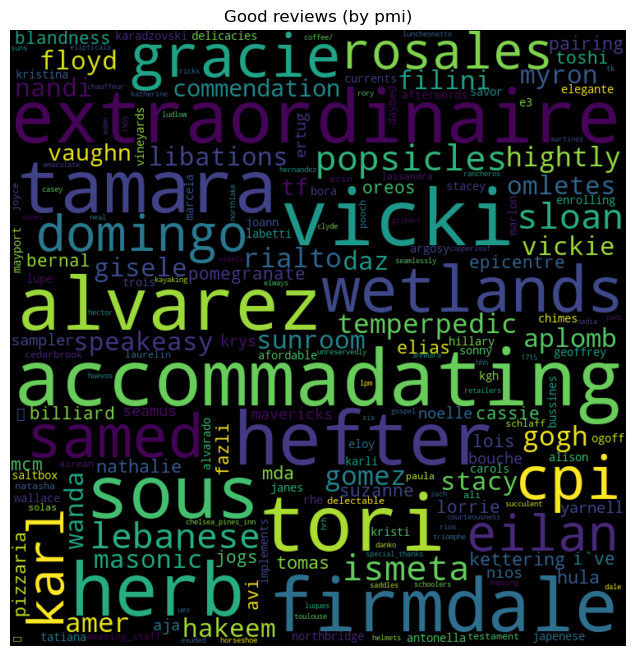

In [50]:
cloud(good_pmi, "Good reviews (by pmi)")

In [ ]:
# The above word cloud has some terms from a language other than english(may be spanish)
